In [32]:
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

# doc2vec tool
import gensim
from gensim.models import doc2vec

# sklearn classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Prepraring for classifiaction

## Computing new cells

In [33]:
# loading data
reviews_df = pd.read_csv('./data/reviews_clean.csv',
                        converters={'Review_lemmatized': pd.eval}) # just this used
                        #converters={'Review_lemmatized': pd.eval, 'Review_stopwords': pd.eval, 'Review_bigrams': pd.eval})

In [34]:
reviews_df.head()

,Review,Rating,Review_processed,Review_lemmatized,Review_stopwords,Review_bigrams,Words_number,Commas,Average_length
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","['nice', 'hotel', 'expensive', 'parking', 'got...","[('nice', 'hotel'), ('hotel', 'expensive'), ('...",86,11,8.333333
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","['ok', 'nothing', 'special', 'charge', 'diamon...","[('ok', 'nothing'), ('nothing', 'special'), ('...",243,20,12.952381
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattl...,"[nice, room, not, experience, hotel, monaco, s...","['nice', 'room', 'experience', 'hotel', 'monac...","[('nice', 'room'), ('room', 'experience'), ('e...",208,16,13.823529
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","['unique', 'great', 'stay', 'wonderful', 'time...","[('unique', 'great'), ('great', 'stay'), ('sta...",88,13,7.428571
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","['great', 'stay', 'great', 'stay', 'went', 'se...","[('great', 'stay'), ('stay', 'great'), ('great...",189,33,6.647059


In [35]:
# creating a list with all words
all_words = []

for rev in reviews_df.Review_lemmatized:
    all_words.extend(rev)
    
len(all_words)

2092254

In [36]:
# analyzing word occurrence number
word_occurrence_number = pd.DataFrame.from_dict(Counter(all_words), orient='index', columns=['occurrence_number'])
word_occurrence_number.describe()

,occurrence_number
count,71900.000000
mean,29.099499
std,414.316660
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,52901.000000


In [37]:
# computing the percentage of
len(word_occurrence_number[word_occurrence_number.occurrence_number > 2])/len(word_occurrence_number)

0.26764951321279556

In [39]:
np.mean(reviews_df.Words_number)

102.105997755112

## Doc2vec

In [40]:
# increased to obtain better performance
n_epochs = 32
# the 75% value from the describe() on the word occurrence
# maybe it is even to high, gonna just after performance
# but this will include around 27 % of the occurring words
min_count = 3
# there are no stop words so the window should not be to big
window_size = 2
# trial and error method with help of get_ratings_most_similar() function
vector_size = 32

In [41]:
# function to which returns a 2D array
# in the first column there is rating of the found vectors
# from the second there are ratings of most similar vectors
def get_ratings_most_similar(doc2vec_model, n: int):
    ratings = []

    for tag in range(n):
        similar_reviews = doc2vec_model.dv.most_similar([str(tag)])

        r = [reviews_df.Rating.iloc[tag]]
        for review_index, _ in similar_reviews:
            r.append(reviews_df.Rating.iloc[int(review_index)])

        ratings.append(r)

    return np.array(ratings)

In [42]:
# function to measure doc2vec performance
# by analyzing the most similar (the nearest 50) vectors
def measure_doc2vec_performance(doc2vec_model):
    ratings = get_ratings_most_similar(doc2vec_model, 50)

    mean_of_similar = [np.mean(similar_ratings) for similar_ratings in ratings[: , 1:]]
    return mean_absolute_error(ratings[:, 0], mean_of_similar)

In [43]:
tagged_words = [doc2vec.TaggedDocument(words=review, tags=[str(i)]) for i, review in enumerate(reviews_df.Review_lemmatized)]

In [44]:
# looking for best vector size
# TO DELETE
old_score = 10000

for min_count in range(2,8):
    # build a model
    doc2vec_model = doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=n_epochs, window=window_size)
    doc2vec_model.build_vocab(tagged_words)
    doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
    doc2vec_model.save("doc2vec-vec32-window2.model")

    new_score = measure_doc2vec_performance(doc2vec_model)
    
    print(f"For minimum size {min_count} the score is: {new_score}")

    if new_score < old_score:
        best_min_count = min_count
        old_score = new_score

KeyboardInterrupt: 

In [45]:
# training the doc2vec model
doc2vec_model = doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=n_epochs, window=window_size)
doc2vec_model.build_vocab(tagged_words)
doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
doc2vec_model.save("doc2vec-vec32-window2.model")

### Trying to verify if the doc2vec embedding worked out

In [46]:
ratings_built_model = get_ratings_most_similar(doc2vec_model, 10)

# closer evaluation of the doc2vec 
for rating in ratings_built_model:
    print(f"The review with rating {rating[0]} has similar documents with mean rating: {np.mean(rating[1:])}")

The review with rating 4 has similar documents with mean rating: 3.6
The review with rating 2 has similar documents with mean rating: 2.9
The review with rating 3 has similar documents with mean rating: 3.1
The review with rating 5 has similar documents with mean rating: 4.8
The review with rating 5 has similar documents with mean rating: 3.4
The review with rating 5 has similar documents with mean rating: 5.0
The review with rating 5 has similar documents with mean rating: 4.5
The review with rating 4 has similar documents with mean rating: 4.3
The review with rating 5 has similar documents with mean rating: 4.9
The review with rating 5 has similar documents with mean rating: 4.1


In [47]:
# testing with custom reviews 
# on purpose not using stop words and lower case
vector_good = doc2vec_model.infer_vector('nice open space area, comfy and relaxing atmosphere, people very cheerful'.split())
vector_bad = doc2vec_model.infer_vector('disgusting food and a lot time to wait for service, unpolite service'.split())

In [48]:
good_review_index = int(doc2vec_model.dv.most_similar(vector_good)[0][0])
print(f"Review with rating {reviews_df.Rating.iloc[good_review_index]}:\n{reviews_df.Review.iloc[good_review_index]}")


Review with rating 5:
great hotel stayed hotel girls weekend away 5, comfortable rooms lots space bathroom toiletries, good wardobes, hotel quiet service good, lazy afternoon pool area good loungers excellent chic seating area.would,  


In [49]:
bad_review_index = int(doc2vec_model.dv.most_similar(vector_bad)[0][0])
print(f"Review with rating {reviews_df.Rating.iloc[bad_review_index]}:\n{reviews_df.Review.iloc[bad_review_index]}")

Review with rating 1:
stay away, horrible service especially hotel restaurants, beautiful property disappoints staff, platinum guest expected courtesy minimum met brusque rude service desk long long waits restaurant especially mirabella virtually ignored, stay resort, starwood properties better,  


## Adding doc2vec column to the dataframe

In [50]:
# adding the word embedding as a new column
reviews_df['Doc2vec'] = reviews_df.Review_lemmatized.apply(lambda text_list: list(doc2vec_model.infer_vector(text_list)))

In [51]:
# creating a dataframe with just used columns
reviews_for_classification = reviews_df[['Review', 'Review_lemmatized', 'Doc2vec', 'Commas', 'Words_number', 'Average_length', 'Rating']]

In [52]:
# saving as csv for faster use in future
reviews_for_classification.to_csv('./data/reviews_for_classification.csv', index=False)

### Loading data

In [ ]:
reviews_for_classification = pd.read_csv("reviews_for_classification.csv", 
                                        converters={'Review_lemmatized': pd.eval, 'doc2vec': pd.eval})

# Classifiaction

In [ ]:
# function for plotting confusion matrix with heatmap by seaborn
def plot_confusion_matrix(y_true, y_pred):
    confusion_M = confusion_M = confusion_matrix(y_true, y_pred)
    possible_reviews = range(1,6)
    confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

    sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10}) 

## SVM Classifier

### Classification just on the embedded document
Viviani said on the lecture that while doing classification we should also consider the number of commas, average word length ans ect.

#### Preparing training and test set

In [53]:
# checking if everything is alright 
# to delete later
len(reviews_for_classification.Doc2vec.iloc[0]) == vector_size

True

In [54]:
# dividing the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_for_classification.Doc2vec.to_list(), 
                                                    reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [55]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [56]:
# learning the model
svc_simplest_input = SVC(C=2)
svc_simplest_input.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [57]:
y_pred = svc_simplest_input.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.52      0.54       139
           2       0.38      0.35      0.36       170
           3       0.40      0.22      0.29       216
           4       0.49      0.45      0.47       614
           5       0.69      0.82      0.75       911

    accuracy                           0.59      2050
   macro avg       0.51      0.47      0.48      2050
weighted avg       0.57      0.59      0.57      2050



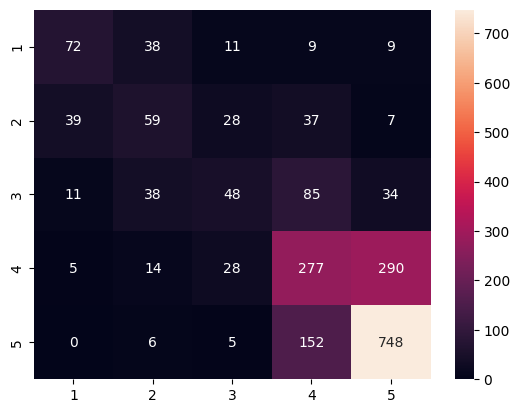

In [58]:
plot_confusion_matrix(y_test, y_pred)

In [59]:
# investigating the performance on the train set
y_train_pred = svc_simplest_input.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7509354156499105

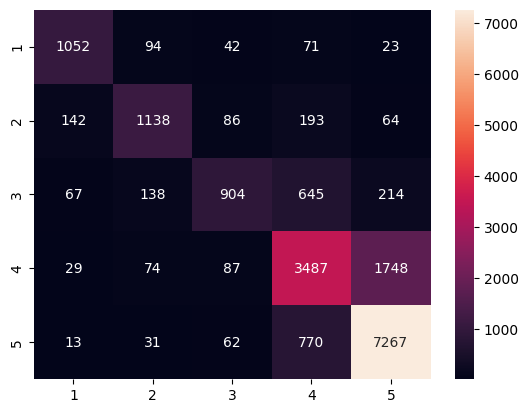

In [60]:
plot_confusion_matrix(y_train, y_train_pred)

### Classification with other parameters

#### Preparing train and test set

In [ ]:
# to delete
# reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)

C:\Users\jjasi\AppData\Local\Temp\ipykernel_21704\2440993339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)


In [61]:
# creating a list of concatenated vectors
X = []

for _, row in reviews_for_classification.iterrows():
    x = row.Doc2vec.copy()
    x.extend([row.Words_number, row.Commas, row.Average_length])
    X.append(x)

# print to delete
len(X[0])

35

In [62]:
# scaling the values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [64]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [65]:
# increasing C to weaken the L2 regularization
# at first the classifier was predicting only rating 5
# therefore it is good to increase variation
svc_metadata = SVC(C=2)
svc_metadata.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [66]:
y_pred = svc_metadata.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.57      0.59       139
           2       0.43      0.38      0.40       170
           3       0.39      0.24      0.30       216
           4       0.49      0.44      0.47       614
           5       0.69      0.82      0.75       911

    accuracy                           0.59      2050
   macro avg       0.52      0.49      0.50      2050
weighted avg       0.57      0.59      0.58      2050



In [67]:
y_train_pred = svc_metadata.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7928528821647416

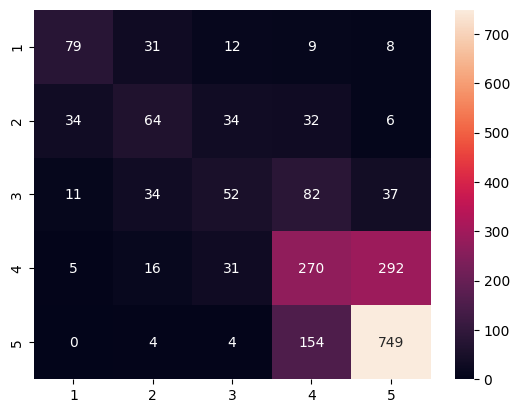

In [68]:
plot_confusion_matrix(y_test, y_pred)

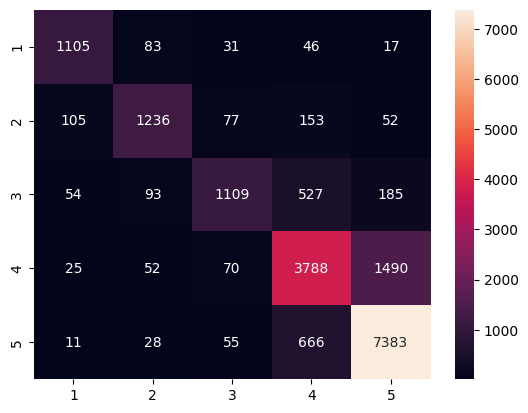

In [69]:
plot_confusion_matrix(y_train, y_train_pred)

The model with the extra inputs works slightly better so from now it will be just this one used.

## KNeighbors

In [70]:
# since it is a very fast non-parametric algorithm
# looking for best performing n_neighbors value
accuracies = []

for n_neighbors in range(1, 50):
    KNC = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNC.fit(X_train, y_train)
    y_pred = KNC.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

In [71]:
best_n_neighbors = np.argmax(accuracies) + 1

In [72]:
KNC = KNeighborsClassifier(n_neighbors=best_n_neighbors)
KNC.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=31)

In [73]:
y_pred = KNC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.42      0.47       139
           2       0.32      0.09      0.14       170
           3       0.48      0.09      0.16       216
           4       0.41      0.40      0.41       614
           5       0.62      0.84      0.71       911

    accuracy                           0.54      2050
   macro avg       0.47      0.37      0.38      2050
weighted avg       0.51      0.54      0.50      2050



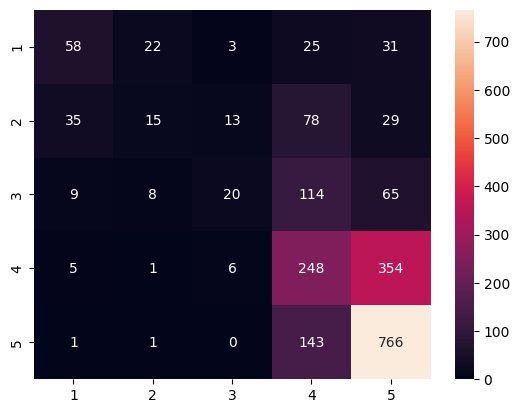

In [74]:
plot_confusion_matrix(y_test, y_pred)

In [75]:
y_train_pred = KNC.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.5755110894203135

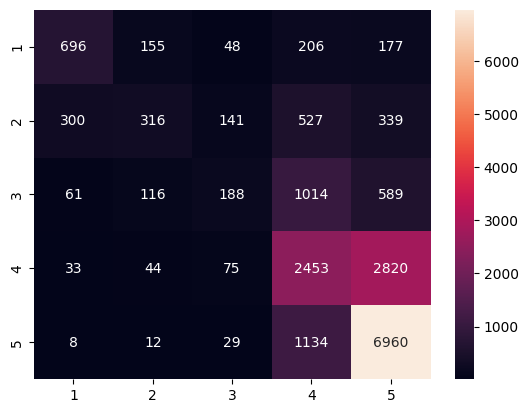

In [76]:
plot_confusion_matrix(y_train, y_train_pred)

## Random Forest

In [77]:
RFC = RandomForestClassifier(max_depth=14, random_state=42)

In [78]:
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, random_state=42)

In [79]:
y_pred = RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.45      0.51       139
           2       0.46      0.25      0.32       170
           3       0.41      0.06      0.10       216
           4       0.43      0.39      0.41       614
           5       0.63      0.86      0.73       911

    accuracy                           0.56      2050
   macro avg       0.50      0.40      0.41      2050
weighted avg       0.53      0.56      0.52      2050



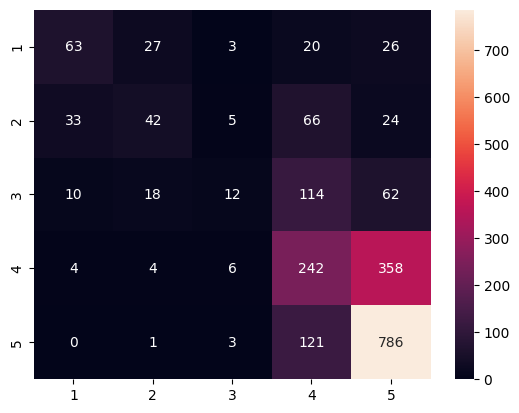

In [80]:
plot_confusion_matrix(y_test, y_pred)

In [81]:
y_train_pred = RFC.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9640475028469172

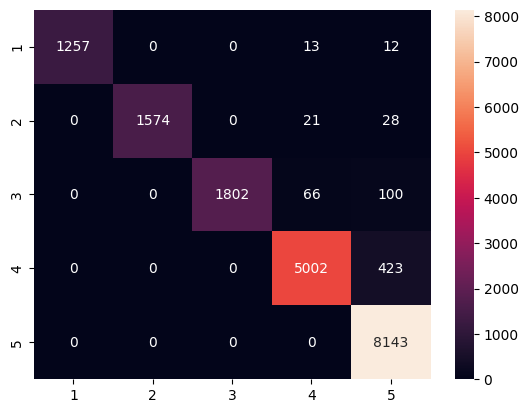

In [82]:
plot_confusion_matrix(y_train, y_train_pred)

## Linear SGD

In [83]:
SGD = SGDClassifier(loss='log_loss', alpha=1e-6, average=10)

In [84]:
SGD.fit(X_train, y_train)

SGDClassifier(alpha=1e-06, average=10, loss='log_loss')

In [85]:
y_pred = SGD.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.50      0.54       139
           2       0.52      0.19      0.28       170
           3       0.45      0.09      0.15       216
           4       0.43      0.45      0.44       614
           5       0.66      0.86      0.75       911

    accuracy                           0.58      2050
   macro avg       0.53      0.42      0.43      2050
weighted avg       0.55      0.58      0.54      2050



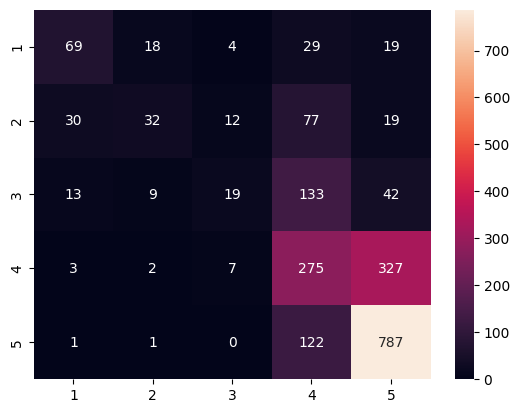

In [86]:
plot_confusion_matrix(y_test, y_pred)

In [87]:
y_train_pred = SGD.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.5756195434087088

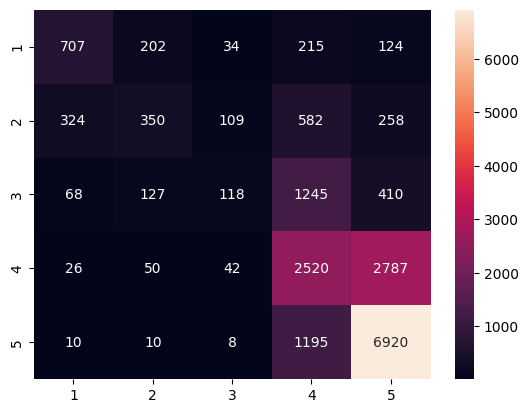

In [88]:
plot_confusion_matrix(y_train, y_train_pred)